In [23]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import cv2
import os
import json
import time
import gc

from patches import Patches, PatchEncoder
from hyperparameters import *
from tools import *

In [24]:
# Load configuration
if os.path.exists('config/localconfig.py'):
    from config import localconfig as config
else:
    from config import config

In [25]:
annot_paths = [f for f in os.listdir(config.BB_TARGET)]

import random
random.shuffle(annot_paths)

images, targets = [], []

In [26]:
size = 1000 # target is len(annot_paths)

for i in range(0, size):
    # Print progress
    if i % (size / 100) == 0:
        print(f'Proceeded {int((i / size) * 100)}%')

    image = keras.utils.load_img(os.path.join(config.BB_IMAGES, annot_paths[i][:-5]))
    w, h = image.size[:2]

    # resize training set
    # if i < int(size * 0.8):
    image = image.resize((image_size, image_size))
    images.append(keras.utils.img_to_array(image))
    del image
    gc.collect()

    with open(os.path.join(config.BB_TARGET, annot_paths[i])) as f:
        targets.append(json.load(f)[0])

Proceeded 0%
Proceeded 1%
Proceeded 2%
Proceeded 3%
Proceeded 4%
Proceeded 5%
Proceeded 6%
Proceeded 7%
Proceeded 8%
Proceeded 9%
Proceeded 10%
Proceeded 11%
Proceeded 12%
Proceeded 13%
Proceeded 14%
Proceeded 15%
Proceeded 16%
Proceeded 17%
Proceeded 18%
Proceeded 19%
Proceeded 20%
Proceeded 21%
Proceeded 22%
Proceeded 23%
Proceeded 24%
Proceeded 25%
Proceeded 26%
Proceeded 27%
Proceeded 28%
Proceeded 28%
Proceeded 30%
Proceeded 31%
Proceeded 32%
Proceeded 33%
Proceeded 34%
Proceeded 35%
Proceeded 36%
Proceeded 37%
Proceeded 38%
Proceeded 39%
Proceeded 40%
Proceeded 41%
Proceeded 42%
Proceeded 43%
Proceeded 44%
Proceeded 45%
Proceeded 46%
Proceeded 47%
Proceeded 48%
Proceeded 49%
Proceeded 50%
Proceeded 51%
Proceeded 52%
Proceeded 53%
Proceeded 54%
Proceeded 55%
Proceeded 56%
Proceeded 56%
Proceeded 57%
Proceeded 59%
Proceeded 60%
Proceeded 61%
Proceeded 62%
Proceeded 63%
Proceeded 64%
Proceeded 65%
Proceeded 66%
Proceeded 67%
Proceeded 68%
Proceeded 69%
Proceeded 70%
Proceeded 71%
Pr

In [27]:
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)

In [28]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (800, 224, 224, 3) - y_train shape: (800, 4)
x_test shape: (200, 224, 224, 3) - y_test shape: (200, 4)


Image size: 224 X 224
Patch size: 16 X 16
196 patches per image 
768 elements per patch


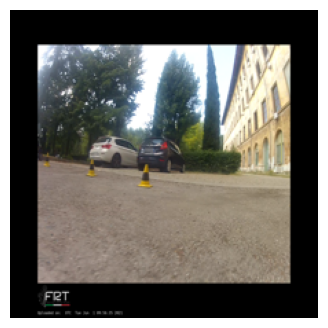

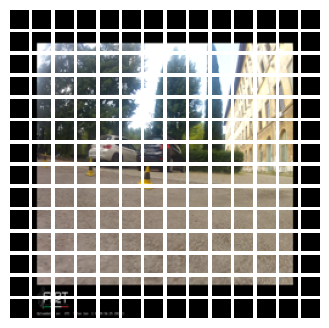

In [29]:
plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [30]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)

In [31]:
def run_experiment(model: tf.keras.Model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=['acc'])

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history

In [32]:
history = []

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
# Saves the model in current path
vit_object_detector.save(f"vit_object_detector_{int(time.time())}.h5", save_format="h5")

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = matplotlib.patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_title('Detected bounding box')
    ax1.set_xlabel(
        f"Predicted: ({top_left_x}, {top_left_y}), ({bottom_right_x}, {bottom_right_y})")

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = matplotlib.patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_title('The largest bounding box')
    ax2.set_xlabel(
        f"Target: ({top_left_x}, {top_left_y}), ({bottom_right_x}, {bottom_right_y})\nIoU{bounding_box_intersection_over_union(box_predicted, box_truth)})"
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()